[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/014_clasificacion_binaria/clasificacion_binaria.ipynb)

# Regresión Logística

En el [post](https://sensioai.com/blog/014_clasificacion_binaria) anterior vimos cómo utilizar el `Perceptrón` para la tarea de clasificación binaria. Para ello utilizamos una función de activación de tipo `step` (que nos da una salida de $0$ ó $1$) y entrenamos el `Perceptrón` mediante el algoritmo de descenso por gradiente utilizando el error medio cuadrático (MSE) como función de pérdida. Sin embargo, en ocasiones no estamos interesados simplemente en conocer si un elemento en particular pertenece a una clase o no, si no también el grado de confianza con el que nuestro modelo da cada predicción. Para ello necesitamos que nuestro `Perceptrón` sea capaz de dar una `probabilidad` a la salida. Como ya hablamos en el post de [probabilidad](https://sensioai.com/blog/010_probabilidad), esta salida será un valor entre $0$ y $1$ (a diferencia del anterior modelo en el que la salida era $0$ ó $1$) siendo $0$ la absoluta certeza de que el elemento en cuestión no pertenece a la clase que nos interesa y $1$ la absoluta certeza de que sí pertenece. Un valor intermedio indicará una menor seguridad por parte del modelo (podemos utilizar esta información para mejorar el algoritmo añadiendo más datos similares). Un valor de $0.5$ indicará que nuestro modelo no tiene ni la más remota idea de cómo clasificar el elemento utilizado como entrada. Este modelo también se conoce por el nombre de `regresión logística` y vamos a ver cómo se define, su implementación y proceso de entrenamiento.

## Función de Activación

Seguimos trabajando con el mismo modelo de `Perceptrón` que ya conocemos de los posts anteriores.

![](https://www.researchgate.net/profile/Shibani_Singh2/publication/321141639/figure/fig2/AS:572731935727616@1513561342872/Schematic-of-Rosenblatts-perceptron.png)

La principal diferencia es que, en el modelo de `regresión logísitca`, utilizaremos una función de activación conocida como `Sigmoid`.

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

Como ya vimos en el post sobre [probabilidad](https://sensioai.com/blog/010_probabilidad), esta función recibirá como entrada un vector con la salida de nuestro perceptrón para unos datos de entrada determinados y lo convertirá en una probabilidad (un valor entre $0$ y $1$).

In [1]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

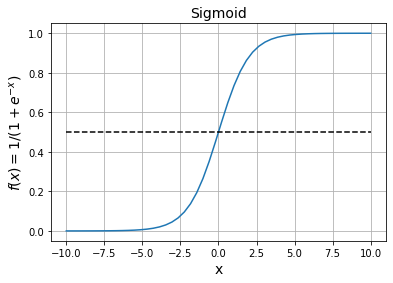

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10)
y = 1. / (1. + np.exp(-x))

plt.plot(x, y)
plt.grid(True)
plt.xlabel('x', fontsize=14)
plt.ylabel('$f(x) = 1/(1 + e^{-x})$', fontsize=14)
plt.title('Sigmoid', fontsize=14)
plt.plot(x, np.full(len(x), 0.5), '--k')
plt.show()

Como podemos ver, los valores muy negativos saturan a un valor de $0$ mientras que los valores muy positivos saturan a un valor de $1$. Cerca de $0$ la función `sigmoid` nos dará una transición suave entre los dos valores límite.

## Función de Pérdida

Podríamos intentar entrenar nuestro modelo de `regresión logísitca` con la función de pérdida que ya conocemos, *MSE*, y de hecho funcionaría sin problemas ya que estamos forzando la salida a tomar el valor $0$ o $1$ en función del *ground truth*. Sin embargo, vamos a introducir una nueva función de pérdida muy utilizada cuando trabajamos con modelos probabilísticos ya que dan como resultado un mejor proceso de optimización. Esta función es conocida como *Binary Cross Entropy*, o también la puedes encontrar por el nombre de *log loss*.

$$ J(\mathbf{w}) = - \frac{1}{N} \sum^{N}_{j=1} \left[ y^{(j)} log(\hat{y}^{(j)}) + (1-y^{(j)})log(1-\hat{y}^{(j)})\right] $$

Como puedes ver, cuando el *ground truth* sea $0$ sólo intervendrá el segundo término, $log(1-\hat{y})$. En este caso, si la salida del modelo es correcta y nos da un valor cercano a $0$ obtendremos un valor de la función de pérdida pequeño. Sin embargo, si el modelo se equivoca y da una probabilidad alta, el valor de la función de pérdida será muy grande indicando un alto error (fíjate en el signo negativo al principio de la expresión, necesario ya que el límite cuando $x$ tiende a $0$ del logaritmo es $- \infty$ pero necesitamos valores positivos para indicar error). Lo mismo se aplica al caso contrario en el que el *ground truth* sea $1$, pero con el primer término. 

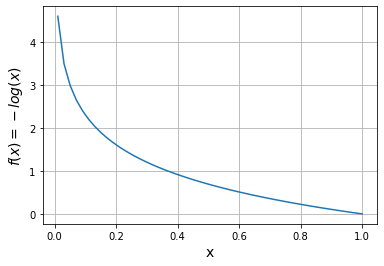

In [4]:
x = np.linspace(0.01, 1)
y =  -np.log(x)

plt.plot(x, y)
plt.grid(True)
plt.xlabel('x', fontsize=14)
plt.ylabel('$f(x) = - log(x)$', fontsize=14)
plt.show()

El motivo por el que usamos logaritmos en la función de pérdida está relacionado con el concepto de `entropía`, una medida del grado de confianza asociado a una distribución de probabilidad. En este post no vamos a entrar en detalle en este concepto, pero si estás interesado [aquí](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) encontrarás más referencias al respecto.

Como bien sabrás ya en este punto (si has seguido nuestros posts anteriores) la función de pérdida no sólo sirve para calcular el error de nuestro modelo, si no también para su entrenamiento. Para ello necesitamos calcular la derivada de la función de pérdida con respecto a los pesos de nuestro modelo. En este caso es un poco más complicado que para la *MSE*, pero con un poco de matemáticas llegamos a la siguiente expresión:

$$ \frac{\partial J}{\partial w_i} =  \frac{1}{N} \sum^{N}_{j=1} (\sigma(\mathbf{w} \cdot \mathbf{x}^{(i)}) - y^{(i)})x^{(j)}_i $$

¿Te resulta familiar? Es exactamente la misma expresión que obtenemos al calcular la derivada de la *MSE* en el caso del `Perceptrón` con función de activación lineal que ya utilizamos para tareas de `regresión`. Esto nos simplifica las cosas a la hora de hacer nuestra implementación.

## Implementación

Vamos a mejorar la implementación del `Perceptrón` del post anterior para que ahora también sea capaz de funcionar como un modelo de `regresión logística`.

In [6]:
# funciones de pérdida

def mse(y, y_hat):
    return np.mean((y_hat - y)**2)

def bce(y, y_hat):
    return - np.mean(y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat))

# funciones de activación

def linear(x):
    return x

def step(x):
    return x > 0

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Perceptron

class Perceptron():
    def __init__(self, size, activation, loss):
        self.w = np.random.randn(size) 
        self.ws = []
        self.activation = activation
        self.loss = loss
    
    def __call__(self, w, x):
        return self.activation(np.dot(x, w)) 

    def fit(self, x, y, epochs, lr):
        x = np.c_[np.ones(len(x)), x]
        for epoch in range(epochs):
            # Batch Gradient Descent
            y_hat = self(self.w, x)  
            # función de pérdida 
            l = self.loss(y, y_hat)
            # derivadas
            dldh = (y_hat - y)
            dhdw = x
            dldw = np.dot(dldh, dhdw)
            # actualizar pesos
            self.w = self.w - lr*dldw
            # guardar pesos para animación
            self.ws.append(self.w.copy())

Como puedes ver hemos definido diferentes funciones para cada una de las funciones de pérdida y de activación que conocemos, y simplemente le diremos al `Perceptrón` cuales utilizar al inicializarlo. De esta manera nuestro modelo será capaz de resolver tanto tareas de `regresión` como de `clasificación binaria`.

> ⚡ Para hacer una implementación todavía más versátil puedes probar a cambiar la función `fit` para que funcione en modo `mini-batch`. En este [post](https://sensioai.com/blog/013_perceptron2) encontraras cómo hacerlo.

## Entrenamiento

Ahora que ya tenemos todas las piezas en su lugar, vamos a utilizar nuestro `Perceptrón` para la tarea de clasificación binaria en el dataset Iris. Si no estás familizarizado con este dataset, te recomiendo que eches un vistazo a los posts anteriores en los que lo explicamos en detalle.

In [7]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

X.shape, y.shape

((150, 2), (150,))

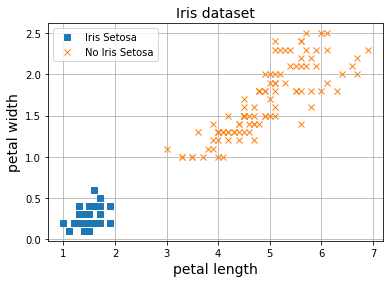

In [8]:
plt.plot(X[y==1, 0], X[y==1, 1], 's', label="Iris Setosa")
plt.plot(X[y==0, 0], X[y==0, 1], 'x', label="No Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [9]:
np.random.seed(42)

perceptron = Perceptron(3, sigmoid, bce)
epochs, lr = 20, 0.01
perceptron.fit(X, y, epochs, lr)

In [10]:
from matplotlib import animation, rc
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
rc('animation', html='html5')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0, 5, 0, 2], label="Iris Setosa"):
    ax.clear()
    w = perceptron.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = np.c_[np.ones(len(X_new)), X_new] 
    y_predict = perceptron(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

Como podemos ver, nuestro modelo es capaz de converger a una solución óptima que separa las dos clases.

> 💡 Prueba a cambiar la función de activación y de pérdida para ver si puedes reprodcir los mismos resultados.

Ahora podemos usar nuestro modelo entrenado para asignar probabilidades de que una flor sea del tipo Iris Setosa a partir de la longitus y el ancho de sus pétalos. 

In [9]:
w = perceptron.ws[-1]
w

array([ 3.1121193 , -1.14317047, -0.70370935])

In [10]:
x_new = [1, 2, 0.5]
y_pred = perceptron(w, x_new)
y_pred # Iris Setosa

0.6163120194730393

In [11]:
x_new = [1, 1, 0.5]
y_pred = perceptron(w, x_new)
y_pred # Iris Setosa

0.8343939887777256

In [12]:
x_new = [1, 3, 0.5]
y_pred = perceptron(w, x_new)
y_pred # No Iris Setosa

0.33866551968712205

In [13]:
x_new = [1, 4, 0.5]
y_pred = perceptron(w, x_new)
y_pred # No Iris Setosa

0.14034623285805609

Como puedes observar, el modelo está más seguro cuanto más nos alejamos de la frontera de decisión (valores más cercanos a $0$ o $1$). Sin embargo, cuanto más cerca de la frontera de decisión nos encontramos, el modelo está menos seguro dando resultados más cercanos a $0.5$. ¿Cómo asignamos una clase u otra entonces? Lo más común es decidir un valor de corte, `threshold`, a partir del cual asignaremos una clase u otra. El valor más común es el de $0.5$ (cualquier valor por encima será asignado a la clase en cuestión). El valor de este `threshold` puede modificarse en cualquier caso para adaptarnos a los criterios de diseño buscados, el ratio entre `falsos positivos` y `falsos negativos`. En posts futuros entraremos en detalle en este asunto, ya que es muy importante sobretodo en aplicaciones sensibles como sistemas de ayuda al diagnóstico médico, por ejemplo.

## Limitaciones

El modelo de `regresión logística` sigue teniendo las mismas limitaciones que encontramos en todas las aplicaciones del `Perceptrón`, y es que no va a ser capaz de proveer de una buena solución cuando nuestros datos no sean fácilmente separables por una línea recta.

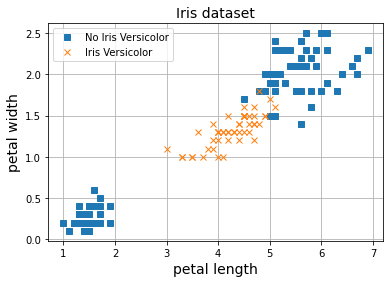

In [14]:
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 1).astype(np.int)

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="No Iris Versicolor")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [15]:
np.random.seed(20)

perceptron = Perceptron(3, sigmoid, bce)
epochs, lr = 40, 0.01
perceptron.fit(X, y, epochs, lr)

In [22]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0.5, 7.3, 0, 2.8], label="Iris Versicolor"):
    ax.clear()
    w = perceptron.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = np.c_[np.ones(len(X_new)), X_new] 
    y_predict = perceptron(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

## Resumen

En este post hemos introducido el modelo de `regresión logística`. Cómo hemos visto, este modelo no es más que nuestro ya conocido `Perceptrón` con una función de activación de tipo `Sigmoid` entrenado con la función de activación *log-loss*. De esta manera, nuestro modelo ahora será capaz no sólo de llevar a cabo la tarea de `clasificación binaria` si no también de darnos el grado de confianza con el que nos proporciona la predicción. Esto lo conseguimos gracias a la función de activación, que convierte la salida del `Perceptrón` en una probabilidad (un valor entre $0$ y $1$). También hemos mejorado nuestra actual implementación del `Perceptrón` de manera que sea capaz de llevar a cabo todas las aplicaciones que hemos visto hasta ahora. Por último, seguimos observando las mismas limitaciones en nuestro modelo, y es que sólo funciona bien cuando los datos pueden ser separados fácilmente por una línea. En el caso contrario, necesitaremos modelos más sofisticados que veremos en futuros posts.

In [21]:
np.c_[np.array([[1,2,3]]), 0, 0,1 ,1 ,np.array([[4,5,6]])]

array([[1, 2, 3, 0, 0, 1, 1, 4, 5, 6]])

In [16]:
np.c_[np.array([1,2,3]), np.array([4,5,6]),np.array([7,8,9])]

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [17]:
np.r_[np.array([1,2,3]), np.array([4,5,6]), np.array([7,8,9])]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [19]:
np.r_[np.array([[1,2,3]]), np.array([[4,5,6]]),np.array([[7,8,9]])]

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])